# Classification with Kernel Fisher Discriminant

###### COMP4670/8600 - Introduction to Statistical Machine Learning - Assignment 1 (due: Monday, 20 April, 23:59)

Name: Lei Wang

Student ID: u5419419

## Instructions

|             |Notes|
|:------------|:--|
|Maximum marks| 20|
|Weight|20% of final grade|
|Format| Complete this ipython notebook. Do not forget to fill in your name and student ID above|
|Submission mode| Use [wattle](https://wattle.anu.edu.au/)|
|Formulas| All formulas which you derive need to be explained unless you use very common mathematical facts. Picture yourself as explaining your arguments to somebody who is just learning about your assignment. With other words, do not assume that the person marking your assignment knows all the background and therefore you can just write down the formulas without any explanation. It is your task to convince the reader that you know what you are doing when you derive an argument.|
| Code quality | Python code should be well structured, use meaningful identifiers for variables and subroutines, and provide sufficient comments. Please refer to the examples given in the tutorials. |
| Code efficiency | An efficient implementation of an algorithm uses fast subroutines provided by the language or additional libraries. For the purpose of implementing Machine Learning algorithms in this course, that means using the appropriate data structures provided by Python and in numpy/scipy (e.g. Linear Algebra and random generators). |
| Late penalty | For every day (starts at midnight) after the deadline of an assignment, the mark will be reduced by 5%. No assignments shall be accepted if it is later than 10 days. | 
| Coorperation | All assignments must be done individually. Cheating and plagiarism will be dealt with in accordance with University procedures (please see the ANU policies on [Academic Honesty and Plagiarism](http://academichonesty.anu.edu.au)). Hence, for example, code for programming assignments must not be developed in groups, nor should code be shared. You are encouraged to broadly discuss ideas, approaches and techniques with a few other students, but not at a level of detail where specific solutions or implementation issues are described by anyone. If you choose to consult with other students, you will include the names of your discussion partners for each solution. If you have any questions on this, please ask the lecturer before you act. |
| Solution | To be presented in the tutorials. |

$\newcommand{\dotprod}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\onevec}{\mathbb{1}}$

Setting up the environment

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
from numpy import linalg as LA
import pandas as pd

%matplotlib inline

## The data set

We will use census data from the [Australian Bureau of Statistics](http://www.abs.gov.au/). The table, which you can [download here](https://sml.forge.nicta.com.au/isml15/data/census_abs2011_summary.csv), contains a set of median and mean values for different regions of Australia.
*(optional information, for interest only) The data consists of values from 2011 of Statistical Areas Level 3 (SA3s) which are often functional areas of regional citeis and large urban transport and service hubs. In general they have populations between 30,000 and 130,000 persons. For details, look at the [source at ABS](http://www.abs.gov.au/websitedbs/censushome.nsf/home/data?opendocument&navpos=200).*

The following code reads in the data using pandas.

In [4]:
raw_data = pd.read_csv('census_abs2011_summary.csv')
print(raw_data.shape)
raw_data.head()

(342, 8)


,Median_age_of_persons_Census_year_2011,Median_mortgage_repayment_monthly_Census_year_2011,Median_rent_weekly_Census_year_2011,Median_total_family_income_weekly_Census_year_2011,Median_total_household_income_weekly_Census_year_2011,Median_total_personal_income_weekly_Census_year_2011,Average_household_size_Census_year_2011,Average_number_of_persons_per_bedroom_Census_year_2011
0,41,1517,180,1307,1015,533,2.5,1.1
1,37,2045,280,2069,1679,830,2.6,1.1
2,38,1300,200,1256,1033,642,2.3,1.1
3,49,1304,209,972,815,438,2.3,1.1
4,41,1950,280,1395,1087,529,2.5,1.1


## (2 points) Plot some characteristics of the data

Display the following two summaries of the data. 1)Please label all the axes, and 2)title the plots appropriately.

* Plot the median monthly mortgage repayment (horizontal axis) to the median weekly rent (vertical axis)

* Plot the histogram of the median age. Use bin boundaries [0,20,30,35,40,45,50,60,80]

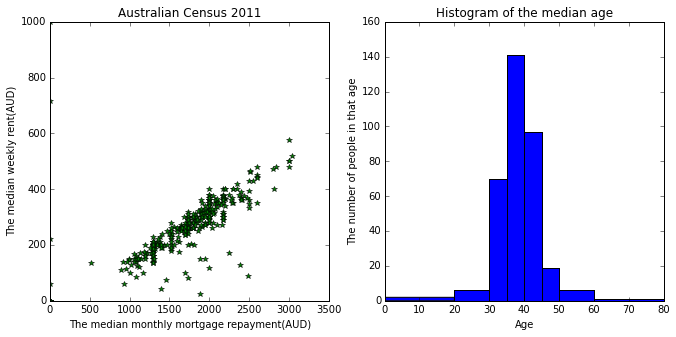

In [5]:
# Solution goes here
fig = plt.figure(figsize=(11,5))
# 1) first graph
#    The median monthly mortgage repayment (horizontal axis) to the median weekly rent (vertical axis)
# x = 'Median_mortgage_repayment_monthly_Census_year_2011'
# y = 'Median_rent_weekly_Census_year_2011'
x = raw_data['Median_mortgage_repayment_monthly_Census_year_2011']
y = raw_data['Median_rent_weekly_Census_year_2011']

ax = fig.add_subplot(121)
ax.plot(x, y, 'g*')
ax.set_title('Australian Census 2011 ')
ax.set_xlabel('The median monthly mortgage repayment(AUD)')
ax.set_ylabel('The median weekly rent(AUD)')

# 2) second graph
#    The histogram of the median age
# Extract the age information
age = raw_data['Median_age_of_persons_Census_year_2011']

ax = fig.add_subplot(122)
ax.hist(age, bins=[0,20,30,35,40,45,50,60,80])       # matplotlib version (plot)
ax.set_title('Histogram of the median age')
ax.set_xlabel('Age')
ax.set_ylabel('The number of people in that age')

The binary classification task under consideration is to predict from the other features, whether the median age in a region is 38 or older.

In [6]:
# if age >= 38, labeled with 1
# else, labeled with -1.
labelvec = np.array(raw_data['Median_age_of_persons_Census_year_2011'])
y = np.ones(len(labelvec))
neg = labelvec < 38
y[neg] = -1 

# positive examples: larger than or equal to 38
# negative examples: smaller than 38
num_pos = len(np.flatnonzero(y > 0))
num_neg = len(np.flatnonzero(y < 0))
print('Number of positive/negative examples = %d/%d' % (num_pos, num_neg))

headers = list(raw_data.columns.values) # get the features' name
headers.remove('Median_age_of_persons_Census_year_2011')
raw_feat = np.array(raw_data[headers]) # feature matrix without age feature  

avg = np.mean(raw_feat,axis = 0)
std_dev = np.std(raw_feat, axis = 0)


X = (raw_feat-avg)/std_dev # scaled features matrix [-1,1]
print X.shape # X is m x n, where m is 342 subjects, n is 7 features
print y.shape # y is m x 1, where m is 342 subjects

Number of positive/negative examples = 187/155
(342, 7)
(342,)


## (3 points) Classification via Fisher's Linear Discriminant

Consider the problem of binary classification. Fisher's criterion is given by:
$$
J(w) = \frac{w^T S_B w}{w^T S_W w}
$$
where $S_B$ is the between class covariance and $S_W$ is the within class covariance.

When implementing this as a linear classifier, you need to choose a threshold in projection space. Describe your criteria for choosing a threshold, and justify why it is a good one.


### 1. Solution description: Describe your criteria for choosing a threshold, and justify why it is a good one.

#### (1) What is a threshold?
In order to reduce dimensionality, we apply Fisher's linear discriminant method. The key technique of this method is to project the $D$-dimensional input vector $x$ down to one-dimentional vector $w$ using

$x_{projection} = w^Tx$

If we place a threshold on $x_{projection}$ and classify $x_{projection} \ge \omega_0  $ as class $\textit{C} _1$, and otherwise class $\textit{C} _2$. 

#### (2) How to find threshold in theory and why we think it is a good one?
We could assume that the each of class histogram resulting from projection onto the vector $w$ is a Gaussian Distribution, $\aleph(\mu_1,\sigma_1^2)$ and $ \aleph(\mu_2,\sigma_2^2)$. That means both of class 1 histogram and class 2 histogram are in same distribution. 
Based on the property of Gaussian distribution, the majority of points would be centered around the mean($\mu_i$). The final goal of Fisher's linear discriminant is to decrease the overlap between two class histograms by maximizing $(\mu_2 - \mu_1)^2$ and minimizing $(\sigma_1^2 + \sigma_2^2)$. Therefore, we would like to choose the midpoint between $\mu_1$ and $\mu_2$ as threshold $\omega_0$. We think it is a good threshold since it is the farthest place for the center of class 1 histogram($\mu_1$) as well as the center of class 2 histogram($\mu_2$), where there are a few points ditributed around that place relatively.

$\omega_0 = 0.5 (\mu_1 + \mu_2)$

#### (3) How to find the threshold using above dataset?
Firstly, we need to find the best direction vector $W = S_w^{-1}(m_1 - m_2)$.

Secondly, we calculate the projection of each class onto the above direction vector $W$, saying $x_{classi\_projection} = W^Tx_{classi}$ where $i \in \{1,2\}$.

Then, we find the mean for each of class projection, saying $\mu_i$ where $i \in \{1,2\}$.

Finally, we get our threshold as $\omega_0 = 0.5 (\mu_1 - \mu_2)$. 

*Attention: In case the distributions of class 1 histogram and class 2 histogram, which is resulted from the projection of each class onto direction vector $W$, are really really different from each other, we could plot these two histogram to see whether they are in similar distribution. If they do, we could choose our threshold in this way.*

###2. Solution Description: Implement two functions ```train_fld``` and ```predict_fld``` that corresponds to training and prediction. The functions should be used as in the following cell.

####(1) Define our Training set
If our training set have m subjects and n features for each subject: 
$\{(x^{(1)}, y^{(1)}),((x^{(2)}, y^{(2)}), ..., ((x^{(m)}, y^{(m)})\}$ , where $y \in \{-1,1\}$ 

$m = a + b$.

There are $a$ trainging sets in class 1:
$\{(x^{(1)}, y^{(1)}),((x^{(2)}, y^{(2)}), ..., ((x^{(a)}, y^{(a)})\}$ , where $y = 1\}$ 

There are $b$ trainging sets in class 1:
$\{(x^{(1)}, y^{(1)}),((x^{(2)}, y^{(2)}), ..., ((x^{(b)}, y^{(b)})\}$ , where $y = -1\}$ 

**Attention: Since our feature matrix in this assignment is read as the transpose format of the feature matrix in theory, we should do matrix product caurefully in our assignment, such as we would define our real direction vector $W$ as a row vector, and the projection of a feature matrix would be $x_{projection} = xW^T$.**

####(2) Training model in theory
The class 1 feature matrix: 

$ x_{class1} =
\begin{bmatrix}
x^{(1)}_1& x^{(2)}_1 & ... & x^{(a)}_1\\ x^{(1)}_2& x^{(2)}_2 & ... & x^{(a)}_2\\...\\ x^{(1)}_n& x^{(2)}_n & ... & x^{(a)}_n\\ 
\end{bmatrix}
=
\begin{bmatrix} 
x^{(1)}& x^{(2)}&...& x^{(m)} 
\end{bmatrix}
=
\begin{bmatrix} 
x_1\\ x_2\\...\\ x_n\\ 
\end{bmatrix}$,where ($ x_{class1} \in R^{ n \times a}$ )



Thus, we could calculate the means ($m_{class 1}$) and covariance($\sigma^{2}_{class1}$).

$m_{1} = 
\begin{bmatrix} 
\frac{1}{a}\sum^{a}_{j = 1}x^{(j)}_1\\ \frac{1}{a}\sum^{a}_{j = 1}x^{(j)}_2\\...\\ \frac{1}{a}\sum^{a}_{j = 1}x^{(j)}_n\\ 
\end{bmatrix}
=
\begin{bmatrix} 
m_{class1\_1}\\ m_{class1\_2}\\...\\ m_{class1\_n}\\ 
\end{bmatrix}$,where ($ m_{ 1} \in R^{ n \times 1}$ )

$\sigma^2_{1} = \sum^{a}_{j = 1}(x^{(i)}-m_1)^2 = \sum^{a}_{j = 1}(x^{(i)}-m_1)(x^{(i)}-m_1)^T$,where ($ \sigma^2_{ 1} \in R^{ n \times n}$ )

Parameter vector(direction vector):

$w = 
\begin{bmatrix}
w_1\\ w_2\\...\\ w_n\\ 
\end{bmatrix} where w \in R^{ n \times 1}$

$ x_{projection\_class1} = w^Tx = 
\begin{bmatrix} 
w_1& w_2&...& w_n 
\end{bmatrix}
\begin{bmatrix} 
x_1\\ x_2\\...\\ x_n\\ 
\end{bmatrix} = 
\begin{bmatrix}
x_{projection\_1\_class1}, x_{projection\_2\_class1},..., x_{projection\_a\_class1}
\end{bmatrix} $ where $ x_{projection} \in R^{ 1 \times a}
$

Therefore, 
$\mu_1 = \frac{1}{a}\sum^{a}_{j = 1}x_{(projection\_j\_class1)}$



**In the same way, we could get $x_{class2}$, $m_2$, $\sigma_2^2$, $x_{projection\_class2}$, and $\mu_2$.**

:) Yeah! We could calculate our $S_w$ now !

$S_w = \sigma_1^2 + \sigma_2^2$

Duang! We get the direction vector $W = S_w^{-1}(m_2 - m_1)$

After we have the direction vector $W$ we can get the threshold $w_0 = 0.5(\mu_1 + \mu_2)$

#### (3) Testing model in theory
Finally, we could predict new data in the following way.

If $W^Tx_{testing} \ge w_0$, then we annotate this subject with class 1 label,

else, we annotate this subject with class 2 label.

**Attention Again: Since our feature matrix in this assignment is read as the transpose format of the feature matrix in theory, we should do matrix product caurefully in our assignment, such as we would define our real direction vector $W$ as a row vector, and the projection of a feature matrix would be $x_{projection} = xW^T$, and the direction vector would be $W = (m_2-m_1)S_w^{-1}$.**

In [26]:
# Solution goes here
"""
Evaluation
"""
def confusion_matrix(prediction, labels):
    """Returns the confusion matrix for a list of predictions and (correct) labels
        prediction = [y_predict1, y_predict2, ..., y_predictm]
        labels = [y_1, y_2, ..., y_m]
        
        reuturn a matrix
        cmatrix = [[tp,fp],[tn,fn]] size: 2 x 2
    """
    assert len(prediction) == len(labels) # make sure there are same example numbers
    def f(pr, la):
        n = 0
        for i in range(len(prediction)):
            if prediction[i] == pr and labels[i] == la:
                n += 1
        return n
    return np.matrix([[f(1, 1), f(1, 0)], [f(0, 1), f(0, 0)]])

def accuracy(cmatrix):
    """Returns the accuracy of a confusion matrix
        accuracy = correct prediction number / all prediction number
    """
    tp, fp, fn, tn = cmatrix.flatten().tolist()[0]
    return 1.0*(tp + tn) / (tp + fp + fn + tn)

def balanced_accuracy(cmatrix):
    """Returns the balanced accuracy of a confusion matrix       
    """
    tp, fp, fn, tn = cmatrix.flatten().tolist()[0]
    return 1.0*tp / 2 / (tp + fn) + 0.5*tn / float(tn + fp)
def drawDistribution(X_projection1, X_projection2):
    """
    We would draw the projection distributions of two classes points onto
    the direction vector w to see wether they are in similar distribution.
    If they do, we could find the threshold by calculate the center of two means 
    of distributions, like w0 = 0.5*(mu_1 + mu_2).
    """
    plt.hist(X_projection1, bins=50, label='class 1(positive)')
    plt.hist(X_projection2, bins=50, label='class 2(negtive)')       # matplotlib version (plot)
    plt.legend(loc='upper right')
    plt.title('Projection onto the w')
    plt.xlabel('projection position')
    plt.ylabel('number of people in same projection position')
    plt.show()

def splitXintoTwoClass(X,y):
    """
    This function is to find the subjects in class1(y>0 positive), and in class2(y<=0 negtive)
    (narray,narray) ---> (narray, narray)
    """
    class1 = y>0
    class2 = y<0
    X_class1 =  X[class1]
    X_class2 = X[class2]
    print X_class1.shape
    return X_class1,X_class2
# TEST FOR FUNCTION splitXintoTwoClass(X,y)
# X_class1,X_class2 = splitXintoTwoClass(X,y)
# print 'TEST FOR FUNCTION splitXintoTwoClass(X,y): ',(len(X_class1.shape)==2)


#################################### Training ######################################
def getMeanAndVariance(X_classi):
    """
    This function would give us the mean and variance for each feature of a feature matrix
    (narray) ---> (narray, narray)
    """
    m_i = X_classi.mean(axis = 0) # we would calculate the mean of each column(feature) of X_classi
    sigma2_i = np.cov(X_classi.T) # we would calculate the corvarince of each column(feature) of X_classi
    N = X_classi.shape[0]
    sigma2_i = sigma2_i*(N-1) # FOLLOW THE LECTURE SLIDS
    return m_i,sigma2_i

# TEST FOR FUNCTION getMeanAndVariance(X_classi)
# X_classi = np.array([[1, 2], [3, 4]])
# m_i,sigma2_i = getMeanAndVariance(X_classi)
# print 'TEST FOR FUNCTION getMeanAndVariance(X_classi) m_i: ',m_i == array([[2.0,3.0]])
# print 'TEST FOR FUNCTION getMeanAndVariance(X_classi) sigma2_i: ',sigma2_i == array([[1.0, 1.0]])

def getDirectionVector(S_w, m_1, m_2):
    W = np.dot(inv(S_w),(m_2.T-m_1.T)) # because our feature matrix is the transpose format of a feature matrix in theory
    return W                    # we get W as W = (m2 - m1)S_w^{-1}, we cannot inverse the position of m_2 and m_1

def getMuAndProjection(W, X_classi):
    X_projection_i = np.dot(X_classi,W.T)
    mu_i = X_projection_i.mean()
    return mu_i,X_projection_i
    
def getThreshold(mu_1,mu_2,n1,n2,n):
    w0 = (1.0*n1/n)*mu_1 + (1.0*n2/n)*mu_2
    return w0
    
def train_fld(X,y):
#1) split X into two classes
    X_class1,X_class2 = splitXintoTwoClass(X,y)
#2) Calculate necessary matrix for each feature class
    m_1,sigma2_1 = getMeanAndVariance(X_class1)
    m_2,sigma2_2 = getMeanAndVariance(X_class2)
    S_w = sigma2_1 + sigma2_2
#3) get the direction vector
    W = 1* getDirectionVector(S_w, m_1, m_2)
#4) get the mean for each projection onto the direction vector
    mu_1,X_projection_1 = getMuAndProjection(W, X_class1)
    mu_2,X_projection_2 = getMuAndProjection(W, X_class2)
## check the distribution of histogram of projection for two classes
    drawDistribution(X_projection_1, X_projection_2)
#5) get the threshold
    w0 = getThreshold(mu_1,mu_2,X_class1.shape[0],X_class2.shape[0],X.shape[0])
    return W,w0


###################################### Testing ##################################

def predict_fld(W, w0,X):
    X_projection = np.dot(X,W.T)
    print X_projection.shape
    class2 = X_projection > w0
    pred = np.ones(len(X))
    pred[class2] = -1
#     pred = np.sign(X_projection - w0)

    return pred

(187, 7)


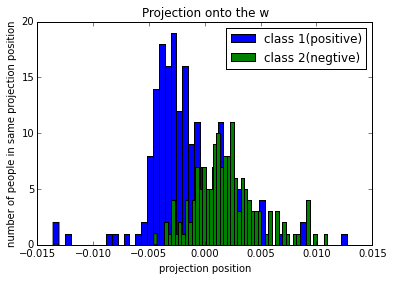

5.42101086243e-19
(342,)
[[137  38]
 [ 50 117]]
0.74269005848 0.743729515267


In [27]:
XTraining = X
yTraining = y
W,w0 = train_fld(XTraining,yTraining)
print w0

XTesting = X
pred = predict_fld(W,w0,XTesting)
# print pred

cmatrix = confusion_matrix((pred+1)/2,(y+1)/2)
print cmatrix
print accuracy(cmatrix),balanced_accuracy(cmatrix)


## (4 points) Kernels

Recall and write down the definitions corresponding to the Gaussian kernel and the inhomogenous polynomial kernel. Please be precise about the meaning of each symbol *(1 point)*.

### Solution
####1.The Gaussian kernel and the inhomogenous polynomial kernel.
#####(1) Gaussian kernel

$k(\mathbf{x},\mathbf{z}) = e^{(- \frac{\left \| \mathbf{x}-\mathbf{z} \right \|^2}{2\sigma^2})}$

$\sigma >0$: The width of kernel window

####(2) Inhomogeneous kernel

$k(\mathbf{x},\mathbf{z}) = (< \mathbf{x},\mathbf{z}>+c)^p$

$c$ is a constant

$p$ is the degree, and also is a constant.


#### (3) Define $\mathbf{x}$ and $\mathbf{z}$ for above kernels
If our training set have m subjects and n features: $\{(x^{(1)}, y^{(1)}),((x^{(2)}, y^{(2)}), ..., ((x^{(m)}, y^{(m)})\}$ , where $y \in \{-1,1\}$ 

$ x_{orginal} =
\begin{bmatrix}
x^{(1)}_1& x^{(2)}_1 & ... & x^{(m)}_1\\ x^{(1)}_2& x^{(2)}_2 & ... & x^{(m)}_2\\...\\ x^{(1)}_n& x^{(2)}_n & ... & x^{(m)}_n\\ 
\end{bmatrix}
= \begin{bmatrix} \mathbf{x^{(1)}_{orginal}} & \mathbf{x^{(2)}_{orginal}}&...&\mathbf{x^{(M)}_{orginal}} \end{bmatrix}
$,where ($ x_{orginal} \in R^{ n \times m}$ )

In order to use kernel, we define the $\mathbf{x}$ and $\mathbf{z}$ we could consider each subject as following

$\mathbf{x} \in \{ \mathbf{x^{(1)}_{orginal}}, \mathbf{x^{(2)}_{orginal}},...,\mathbf{x^{(M)}_{orginal}}\}$ where $\mathbf{x} \in R^{n \times 1}$

$\mathbf{z} \in \{ \mathbf{x^{(1)}_{orginal}}, \mathbf{x^{(2)}_{orginal}},...,\mathbf{x^{(M)}_{orginal}}\}$ where $\mathbf{z} \in R^{n \times 1}$

###2. Implement two functions corresponding to the kernels above *(2 points)*.

In [22]:
def gaussianKernel(x,z,sigma):
    """
    x: the column vector for each subject, where includes all features
    z: landmarks, the column vector for each subject, where includes all features
    sigma: a constant
    return a constant k, we could view it as the similarity of x and z
    """
    k = np.exp(-1.0 *np.power(LA.norm(x - z),2)/(2.0*np.power(sigma,2)) )
    return k

#TEST
# a = array([[2,1]])
# b = array([[1,0]])
# print a.T,'\n', b.T
# print power(norm(a-b),2)
# print power(3,2)
# print gaussianKernel(a,b,3)

def inhomoKernel(x,z,c,p):
    """
    x: the column vector for each subject, where includes all features
    z: landmarks, the column vector for each subject, where includes all features
    c,p : a constant
    return a constant from k, where k array only have one element
    
    """
    k = np.power((np.inner(x,z)+c*1.0),p)
    return k

#TEST
# a = array([[2,1]])
# b = array([[1,0]])
# print a.T,'\n', b.T
# print inhomoKernel(a,b,1,2)


Compute the kernel matrix on all the examples above, and plot the eigenvalues of the kernel matrix. Show results for the Gaussian kernel with width $\sigma=1.1$ and the polynomial kernel with $c=1$ of order 2 and 3 *(1 point)*.

In [23]:
def getGaussianKernelMatrix(X,sigma):
    """
    X: the origianl feature matrix, where X \in R^{n \times m}
    sigma : a given constant
    return K: the gaussian kernel matrix, where K \in R^{m \times m}
    """
    n,m = X.shape
    K = np.zeros((m,m))
    for j in xrange(0, m):
        for i in xrange(0, m):
            xi = X[:,i]
            xj = X[:,j]
            kij = gaussianKernel(xi,xj,sigma)
            K[i,j] += kij
    return K

# Test
# a = array([[2,1],[1,0]])
# print getGaussianKernelMatrix(a,3)

def getInhomoKernelMatrix(X,c,p):
    """
    X: the origianl feature matrix, where X \in R^{n \times m}
    sigma : a given constant
    return K: the gaussian kernel matrix, where K \in R^{m \times m}
    """
    n,m = X.shape
    K = np.zeros((m,m))
    for j in xrange(0, m):
        for i in xrange(0, m):
            xi = X[:,i]
            xj = X[:,j]
            kij = inhomoKernel(xi,xj,c,p)
            K[i,j] += kij
    return K
# Test
# a = array([[2,1],[1,0]])
# print getInhomoKernelMatrix(a,1,2)   

def plotEigenValues(K):
    la, v = LA.eig(K)
    # eigenvalues
    m,m= K.shape
    xaxis = np.r_[1:m+1]
    yaxis = la
    plt.plot(xaxis,yaxis,'x')
    #difine the range of x axis and y axis 
    plt.title('Eigen values for Kernel matrix')
    plt.xlabel('Each egien vector')
    plt.ylabel('egien value')
    plt.show()
# Test
# a = array([[2,1],[1,0]])
# K = getInhomoKernelMatrix(a,1,2) 
# plotEigenValues(K)

In [24]:
Xkernel = X.T
sigma = 1.1
KGaussian = getGaussianKernelMatrix(Xkernel,sigma)
c1 = 1
p1 = 2
Kinhomo1 = getInhomoKernelMatrix(Xkernel,c1,p1) 
c2 = 1
p2 = 3
Kinhomo2 = getInhomoKernelMatrix(Xkernel,c2,p2)

('There are', 342, 'eigen values')
 Gaussian kernel with sigma = 1.1
[[  1.00000000e+00   2.66892123e-02   7.72404607e-01 ...,   1.46643637e-02
    7.75070645e-03   2.06825483e-24]
 [  2.66892123e-02   1.00000000e+00   2.93306194e-02 ...,   2.30354982e-04
    2.40291875e-05   5.51708447e-29]
 [  7.72404607e-01   2.93306194e-02   1.00000000e+00 ...,   1.07355958e-02
    1.47418440e-02   1.60155518e-23]
 ..., 
 [  1.46643637e-02   2.30354982e-04   1.07355958e-02 ...,   1.00000000e+00
    1.88653751e-01   1.02673137e-30]
 [  7.75070645e-03   2.40291875e-05   1.47418440e-02 ...,   1.88653751e-01
    1.00000000e+00   7.55227473e-30]
 [  2.06825483e-24   5.51708447e-29   1.60155518e-23 ...,   1.02673137e-30
    7.55227473e-30   1.00000000e+00]]


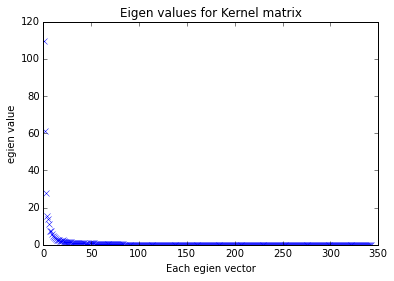

In [25]:
print ('There are',KGaussian.shape[0], 'eigen values')
print' Gaussian kernel with sigma = 1.1'
print KGaussian
plotEigenValues(KGaussian)

('There are', 342, 'eigen values')
 Polynomial kernel with c=1 of order 2


/Users/bud/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy/core/numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


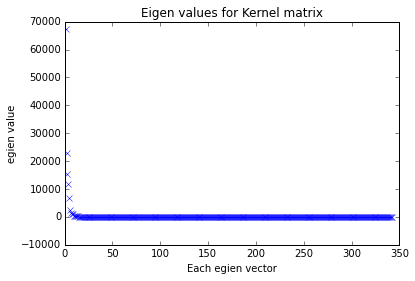

In [47]:
print ('There are',Kinhomo1.shape[0],'eigen values')
print ' Polynomial kernel with c=1 of order 2'
plotEigenValues(Kinhomo1)

('There are', 342, 'eigen values')
 Polynomial kernel with c=1 of order 3


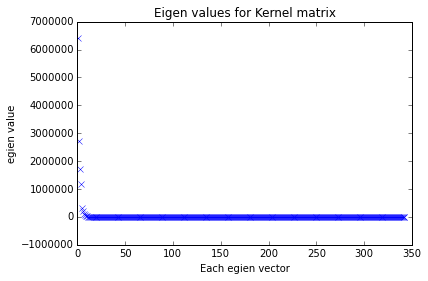

In [48]:
print ('There are',Kinhomo2.shape[0], 'eigen values')
print ' Polynomial kernel with c=1 of order 3'
plotEigenValues(Kinhomo2)

## (4 points) Normalisation in using kernels

You have seen the importance of normalisation in the tutorials.

In the following, we use the fact that kernels ($k(\cdot, \cdot)$) are inner products in a feature space with feature mapping $\phi(\cdot)$:
$$k(x,y) = \dotprod{\phi(x)}{\phi(y)}$$

### Centering

Centering causes the mean of the data set to be the zero vector in feature space. The following is a derivation for doing the centering directly using kernels.

$$
\mu = \frac{1}{n}\sum_{i=1}^n \phi(x_i)
$$
then
$$
\hat{\phi}(x) = \phi(x) - \mu.
$$
Hence
\begin{align*}
\hat{k}(x,y) &= \dotprod{\hat{\phi}(x)}{\hat{\phi}(y)}\\
    &= \dotprod{\phi(x) - \mu}{\phi(y) - \mu}
\end{align*}

Justify and explain the above steps.

### Solution description
#### 1. Basic defination
Given a finite subset $S = \{\mathbf{x_1}, \mathbf{x_2}, ..., \mathbf{x_n}\}$ of an input space $\mathbf{X}$, a kernel $k(\mathbf{x}, \mathbf{y})$ and a feature map $\phi$ into a feature space $\mathbf{F}$ satisfying

$k(\mathbf{x}, \mathbf{y}) = <\phi(\mathbf{x}),\phi(\mathbf{y})> = \phi(\mathbf{x})^T\phi(\mathbf{y}) = \phi(\mathbf{y})^T\phi(\mathbf{x}) $ ,where $\mathbf{x}$ and $\mathbf{y}$ are both a column vector.

Thus, we could get the image of the finite subset $S$ after feature mapping, that is $\phi(S) = \{\phi(\mathbf{x_1}),\phi(\mathbf{x_2}),...,\phi(\mathbf{x_n})\}$. Now elements in collection $\phi(S)$ are a subset of the inner product space $F$. With specific arranging a set of inner product of different combination of two elements in $\phi(S)$, we could get the kernel matrix as $\mathbf{K} = k(\mathbf{x_i},\mathbf{x_j})$, where $i,j = 1,2,...,n$.

The reason why our observation focus on a kernel-defined feature space $F$ but not directly on the vector $\phi(\mathbf{x})$ is that sometimes we cannot find a way to access to each components of such kind of vector. Thus, we would like to evaluate the inner products between two kinds of vector, such as $k(\mathbf{x}, \mathbf{y}) = <\phi(\mathbf{x}),\phi(\mathbf{y})>$.


#### 2. The meaning of $\mu$
In feature space $F$, we assume that we could calculate the centre of mass of the set $\mu = \phi_S$ as

$\phi_S = \frac{1}{n}\sum_{i = 1}^{n}\phi(x_i)$, where $\phi_S$ is a column vector.

However, since we cannot figure out what explicit components in vector $\phi(\mathbf{x})$, we also are not sure what the explicit components in vector $\phi_S$. In this case we need to pay attention to this points. 
####3 The meaning of $\hat{\phi}(x)$
Actually,  $\hat{\phi}(x)$ is the distance from the centre of mass $\mu =\phi_S$.

 $\hat{\phi}(x)$ = $\phi(x)-\phi_S $

####4 Proof for existence of new kernel $\hat{k}(\mathbf{x},\mathbf{y})$
The reason why we want to transform to kernel format is that we could only observe inner products between the distance from the centre of mass $\phi_S$ of two points which are in set $S$.

Considering$< \hat{\phi}(x), \hat{\phi}(y)>$

$= < \phi(x)-\phi_S ,\phi(y)-\phi_S >$

$= (\phi(x)-\phi_S)^T(\phi(y)-\phi_S)
= (\phi(x)^T-\phi_S^T)(\phi(y)-\phi_S)$

$= \phi(x)^T\phi(y)-\phi_S^T\phi(y)-\phi(x)^T\phi_S+\phi_S^T\phi_S$

$= k(x,y)-\frac{1}{n}\sum_{i = 1}^{n}k(x_i,y)-\frac{1}{n}\sum_{i = 1}^{n}k(x,x_i)+\frac{1}{n^2}\sum_{i,j = 1}^{n}k(x_i,x_j)$

We find $< \hat{\phi}(x), \hat{\phi}(y)>$ is a linear combination of several known kernel function $k(x,y)$. 

Therefore, we could define a new kernel function as $\hat{k}(\mathbf{x},\mathbf{y}) = < \hat{\phi}(x), \hat{\phi}(y)>$

####5 Centering  operation on the kenerl matrix
$\hat{\mathbf{K}} = \mathbf{K} - \mathbf{J} - \mathbf{J}^T + \mathbf{E}$

$\mathbf{J} = \frac{1}{n}\mathbf{1_{nx1}}\mathbf{1_{1xn}}\mathbf{K}$

$\mathbf{E} = \frac{1}{n^2}(\mathbf{1_{1xn}}\mathbf{K}\mathbf{1_{nx1}})\mathbf{1_{nx1}}\mathbf{1_{1xn}}$

$\mathbf{1_{ixj}} = \begin{bmatrix} 1 & 1 &... &1\\ 1 & 1 &... &1\\...\\ 1 & 1 &... &1 \end{bmatrix}$, where $\mathbf{1_{ixj}} \in R^{i \times j}$ 

### Unit diagonal

It is often convenient to have all the examples to be represented by vectors of the same length. This implies that the diagonal of the kernel matrix (the squared length) is the same for all examples. We arbitrarily (without loss of generality) set this length to 1.
\begin{align*}
\hat{k}(x,y) &= \dotprod{\frac{\phi(x)}{\|\phi(x)\|}}{\frac{\phi(y)}{\|\phi(y)\|}}\\
    &= \frac{1}{\|\phi(x)\|\|\phi(y)\|}\dotprod{\phi(x)}{\phi(y)}\\
    &= \frac{1}{\|\phi(x)\|\|\phi(y)\|} k(x,y)
\end{align*}

Normalizing the kernel matrix such that it has one along the diagonal is sometimes called trace normalisation or spherical normalisation.

Justify and explain each step of the derivation above.


### Solution description
####1 Norm of feature vector
$\|\phi(x)\|= \sqrt{\left \| \phi(x) \right \|^2} = \sqrt{ \left \langle \phi(x) ,\phi(x)  \right \rangle} = \sqrt{k(x,x)}$
####2 Normalisation for feature vector
\begin{align*}\frac{\phi(x)}{\|\phi(x)\|} = \frac{\phi(x)}{\sqrt{k(x,x)}}\end{align*}
####3 Proof for existence of new kernel $\hat{k}(x,y)$
Considering

\begin{align*}\dotprod{\frac{\phi(x)}{\|\phi(x)\|}}{\frac{\phi(y)}{\|\phi(y)\|}}\\
    &= \frac{\dotprod{\phi(x)}{\phi(y)}}{\|\phi(x)\|\|\phi(y)\|}\\
    &= \frac{ k(x,y)}{\|\phi(x)\|\|\phi(y)\|}\\
    &= \frac{k(x,y)}{\sqrt{k(x,x)}\sqrt{k(y,y)}} \end{align*}
####4 Normalising a kernel matrix
We know our kernel matrix is

$ \mathbf{K} =
\begin{bmatrix}
k(x_1,x_1)& k(x_1,x_2) & ... & k(x_1,x_n)\\
k(x_2,x_1)& k(x_2,x_2) & ... & k(x_2,x_n)\\
...\\
k(x_n,x_1)& k(x_n,x_2) & ... & k(x_n,x_n)\\ 
\end{bmatrix}
$,where ($\mathbf{K} \in R^{ n \times n}$ )

If we transform each element in above kernel matrix with $\hat{k}(x,y)$, we could get the normalised kernel matrix as following.

$ \hat{\mathbf{K}}=
\begin{bmatrix}
\frac{1}{\sqrt{k(x_1,x_1)}}k(x_1,x_1)\frac{1}{\sqrt{k(x_1,x_1)}}& \frac{1}{\sqrt{k(x_1,x_1)}}k(x_1,x_2)\frac{1}{\sqrt{k(x_2,x_2)}} & ... & \frac{1}{\sqrt{k(x_1,x_1)}}k(x_1,x_n)\frac{1}{\sqrt{k(x_n,x_n)}}\\
\frac{1}{\sqrt{k(x_2,x_2)}}k(x_2,x_1)\frac{1}{\sqrt{k(x_1,x_1)}}& \frac{1}{\sqrt{k(x_2,x_2)}}k(x_2,x_2)\frac{1}{\sqrt{k(x_2,x_2)}} & ... & \frac{1}{\sqrt{k(x_2,x_2)}}k(x_2,x_n)\frac{1}{\sqrt{k(x_n,x_n)}}\\
...\\
\frac{1}{\sqrt{k(x_n,x_n)}}k(x_n,x_1)\frac{1}{\sqrt{k(x_1,x_1)}}& \frac{1}{\sqrt{k(x_n,x_n)}}k(x_n,x_2)\frac{1}{\sqrt{k(x_2,x_2)}} & ... & \frac{1}{\sqrt{k(x_n,x_n)}}k(x_n,x_n)\frac{1}{\sqrt{k(x_n,x_n)}}\\ 
\end{bmatrix}
$,where ($\hat{\mathbf{K}} \in R^{ n \times n}$ )

We build a diagonal matrix to store the inverse of the norms as $D$.

$ \mathbf{D}=
\begin{bmatrix}
\frac{1}{\sqrt{k(x_1,x_1)}}& 0 &0& ... & 0\\
0& \frac{1}{\sqrt{k(x_2,x_2)}}&0& ... & 0\\
0&0& \frac{1}{\sqrt{k(x_3,x_3)}}& ... & 0\\
...\\
0& 0&0& ... & \frac{1}{\sqrt{k(x_n,x_n)}}\\ 
\end{bmatrix}
$,where ($\mathbf{D} \in R^{ n \times n}$ )

Thus, our normalised kernel matrix could be formed by orignal kernel matrix and diagonal matrix.

$ \hat{\mathbf{K}}= \mathbf{D}\mathbf{K}\mathbf{D} $


In [14]:

"""
Centering and Normalisation of kernel
"""
# Centering
def center(K):
    """Center the kernel matrix, such that the mean (in feature space) is zero."""
    n = K.shape[0]
    one_nx1 = np.ones((n,1))
    one_nxn = np.ones((n,n))
    D = K.mean(axis = 0)
    J = one_nx1*D
    E = D.mean()*one_nxn
    C = K - J -J.T +E   
    return C

#Normalising
def normalise_unit_diag(K):
    """Normalise the kernel matrix, such that all diagonal entries are 1."""
    D_vector = 1.0/np.sqrt(np.diag(K)) 
    D = np.diag(D_vector, k = 0)
    R = np.dot(D,np.dot(K,D))
    return R
# #Testing
# a = array([[1,2,3],[4,5,6],[7,8,9]])
# R = normalise_unit_diag(a)
# print R

$\newcommand{\dotprod}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\onevec}{\mathbb{1}}$
## (3 points) Kernelising Fisher's Discriminant

### Definition
Consider a binary classification task.
Recall from the lecture that Fisher's criterion is given by:
$$
J(w) = \frac{(m_2 - m_1)^2}{s_1^2 + s_2^2}
$$
where $m_1$ and $m_2$ are the means of class $\mathcal{C}_1$ and $\mathcal{C}_2$ respectively, and $s_1^2$ and $s_2^2$ are the corresponding within class variances.

Write down the definition of $m_1, m_2, s_1, s_2$ in terms of the examples $\mathbf{x}$ and the labels $y$. Please define all your symbols carefully, in particular $\mathbf{w}$.

### Solution

####(1) Assumption
If our training set have m subjects and n features for each subject: 
$\{(x^{(1)}, y^{(1)}),((x^{(2)}, y^{(2)}), ..., ((x^{(m)}, y^{(m)})\}$ , where $y \in \{-1,1\}$ 

$m = a + b$.

There are $a$ trainging sets in class 1:
$\{(x^{(1)}, y^{(1)}),((x^{(2)}, y^{(2)}), ..., ((x^{(a)}, y^{(a)})\}$ , where $y = 1\}$ 

There are $b$ trainging sets in class 1:
$\{(x^{(1)}, y^{(1)}),((x^{(2)}, y^{(2)}), ..., ((x^{(b)}, y^{(b)})\}$ , where $y = -1\}$ 
####(2) More detials on feature matrix
The class 1 feature matrix: 

$ \mathbf{x}_{class1} =
\begin{bmatrix}
x^{(1)}_1& x^{(2)}_1 & ... & x^{(a)}_1\\ x^{(1)}_2& x^{(2)}_2 & ... & x^{(a)}_2\\...\\ x^{(1)}_n& x^{(2)}_n & ... & x^{(a)}_n\\ 
\end{bmatrix}
=
\begin{bmatrix} 
\mathbf{x}_1\\ \mathbf{x}_2\\...\\ \mathbf{x}_n\\ 
\end{bmatrix}$,where ($ \mathbf{x}_{class1} \in R^{ n \times a}$ )

We can describe the class 2 feature matrix $ x_{class2}$ in the same way.

####(3) Define the projection:

In order to reduce dimensionality, we apply Fisher's linear discriminant method. The key technique of this method is to project the D-dimensional input vector $\mathbf{x}$ down to one-dimentional vector $\mathbf{w}$ using

$ \mathbf{x}_{projection}=\mathbf{w}^T\mathbf{x} $

where direction vector:

$ \mathbf{w} = 
\begin{bmatrix}
w_1\\ w_2\\...\\ w_n\\ 
\end{bmatrix}$ where $w \in R^{ n \times 1}$

$ \mathbf{x}_{projection\_class1} = \mathbf{w}^T\mathbf{x_{class1}} = 
\begin{bmatrix} 
w_1& w_2&...& w_n 
\end{bmatrix}
\begin{bmatrix} 
x_1\\ x_2\\...\\ x_n\\ 
\end{bmatrix} = 
\begin{bmatrix}
x_{projection\_1\_class1}, x_{projection\_2\_class1},..., x_{projection\_a\_class1}
\end{bmatrix} $ where $ x_{projection\_1\_class1} \in R^{ 1 \times a}$

We also could provide the class 2 projection in the same way.

####(4) Define $m_i$ and $S_i^2$
After we get the projection of both classes onto direction vector $\mathbf{w}$, we could find  $m_i$ and $S_i^2$ where $i = \{1,2\}$.

$m_1 = \frac{1}{a}\sum^{a}_{j = 1}x_{(projection\_j\_class1)} $, where $m_1$ is a constant.

$S_1^2 = \sum^{a}_{j = 1}(x_{(projection\_j\_class1)} - m_1)^2$

$m_2 = \frac{1}{b}\sum^{b}_{j = 1}x_{(projection\_j\_class2)}$, where $m_2$ is a constant.

$S_2^2 = \sum^{b}_{j = 1}(x_{(projection\_j\_class2)} - m_2)^2$



### Matrix form

Observe that you can express the sum of a set of vectors as a product of a vector of ones, $\onevec$ and a matrix containing the vectors. Define matrices $\mathbf{X}_1$ and $\mathbf{X}_2$ as the data corresponding to class $C_1$ and $C_2$ respectively. Please specify the dimensions carefully. Using these definitions, derive the expression for the numerator of $J(w)$, i.e. $(m_2 - m_1)^2$ where the data only appears in terms of the matrices $\mathbf{X}_1\mathbf{X}_1^T$, $\mathbf{X}_1\mathbf{X}_2^T$, $\mathbf{X}_2\mathbf{X}_1^T$ and $\mathbf{X}_2\mathbf{X}_2^T$. There could be other vectors, for example $\mathbf{w}$.

### Solution
####(1) Define the mean of row vector $\mathbf{x}$ wih matrix form
$\mathbf{x} = \begin{bmatrix} x_1& x_2&...& x_m \end{bmatrix}$ where $\mathbf{x} \in R^{1 \times m}$

$mean = \frac{1}{m}\sum^{m}_{i = 1}x_i  = \frac{1}{m}\begin{bmatrix} x_1& x_2&...& x_m \end{bmatrix}\begin{bmatrix} 1\\ 1\\...\\ 1 \end{bmatrix} = \frac{1}{m}\mathbf{x}\mathbf{1_{mx1}}$  ,where $\mathbf{1_{mx1}} \in R^{m \times 1}$.

Thus, according to the above assumption, we define

$m_1 = \frac{1}{a}\sum^{a}_{j = 1}x_{projection\_j\_class1} = \frac{1}{a}\mathbf{X}_{projection\_class1}\mathbf{1_{ax1}}=
\frac{1}{a}\mathbf{w}^T\mathbf{X}_1\mathbf{1_{ax1}}$,where $\mathbf{1_{ax1}} \in R^{a \times 1}$ and $a$ is the number of subjects in class 1.

$m_2 = \frac{1}{b}\sum^{b}_{j = 1}x_{projection\_j\_class2} = \frac{1}{b}\mathbf{X}_{projection\_class2}\mathbf{1_{bx1}}=
\frac{1}{b}\mathbf{w}^T\mathbf{X}_2\mathbf{1_{bx1}}$,where $\mathbf{1_{bx1}} \in R^{b \times 1}$ and $b$ is the number of subjects in class 2.

####(2) Define the square of row vector $\mathbf{x}$ wih matrix form
$\mathbf{x} = \begin{bmatrix} x_1& x_2&...& x_m \end{bmatrix}$ where $\mathbf{x} \in R^{1 \times m}$

$\mathbf{x}\mathbf{x}^T = \begin{bmatrix} x_1& x_2&...& x_m \end{bmatrix}\begin{bmatrix} x_1\\ x_2\\...\\ x_m \end{bmatrix} = x_1^2 + x_2^2 + ... + x_m^2$

If $m = 1$, that means there is only on element in row vector $\mathbf{x}$, so

$\mathbf{x} = \begin{bmatrix} x_1\end{bmatrix}$ where $\mathbf{x} \in R^{1 \times 1}$

$\mathbf{x}\mathbf{x}^T = x_1^2$

####(3) Define the $(m_2- m_1)^2$ with matrix form
If we define

$\mathbf{m_1} = \begin{bmatrix} (m_1)\end{bmatrix} = m_1\mathbf{1_{1x1}}$ where $\mathbf{m_1}, \mathbf{1_{1x1}} \in R^{1 \times 1}$

$\mathbf{m_2} = \begin{bmatrix} (m_2)\end{bmatrix}= m_2\mathbf{1_{1x1}}$ where $\mathbf{m_2}, \mathbf{1_{1x1}} \in R^{1 \times 1}$


we build a matrix $\mathbf{x} = \mathbf{m_2}-\mathbf{m_1} = \begin{bmatrix} (m_2- m_1)\end{bmatrix}$ where $\mathbf{x} \in R^{1 \times 1}$

$\mathbf{x}\mathbf{x}^T = (\mathbf{m_2}-\mathbf{m_1})(\mathbf{m_2}-\mathbf{m_1})^T= (m_2- m_1)^2$

and from (1) we know $m_1=\frac{1}{a}\mathbf{w}^T\mathbf{X}_1\mathbf{1_{ax1}}$,where $\mathbf{1_{ax1}} \in R^{a \times 1}$ and $a$ is the number of subjects in class 1. $m_2=\frac{1}{b}\mathbf{w}^T\mathbf{X}_2\mathbf{1_{bx1}}$,where $\mathbf{1_{bx1}} \in R^{b \times 1}$ and $b$ is the number of subjects in class 2.

so we get

$\mathbf{m_1} = m_1\mathbf{1_{1x1}} =\frac{1}{a}\mathbf{w}^T\mathbf{X}_1\mathbf{1_{ax1}} \mathbf{1_{1x1}}$, where $\mathbf{1_{ax1}} \in R^{a \times 1}$ and $\mathbf{1_{1x1}} \in R^{1 \times 1}$

$\mathbf{m_2} = m_2\mathbf{1_{1x1}} =\frac{1}{b}\mathbf{w}^T\mathbf{X}_2\mathbf{1_{bx1}} \mathbf{1_{1x1}}$, where $\mathbf{1_{bx1}} \in R^{b \times 1}$ and $\mathbf{1_{1x1}} \in R^{1 \times 1}$

Thus,

$\mathbf{x}\mathbf{x}^T=(\mathbf{m_2}-\mathbf{m_1})(\mathbf{m_2}-\mathbf{m_1})^T = (m_2- m_1)^2$

=
$(\frac{1}{b}\mathbf{w}^T\mathbf{X}_2\mathbf{1_{bx1}} 
\mathbf{1_{1x1}}-\frac{1}{a}\mathbf{w}^T\mathbf{X}_1\mathbf{1_{ax1}}
\mathbf{1_{1x1}})(\frac{1}{b}\mathbf{w}^T\mathbf{X}_2\mathbf{1_{bx1}} 
\mathbf{1_{1x1}}-\frac{1}{a}\mathbf{w}^T\mathbf{X}_1\mathbf{1_{ax1}} \mathbf{1_{1x1}})^T$

=
$(\mathbf{w}^T(\frac{1}{b}\mathbf{X}_2\mathbf{1_{bx1}} 
\mathbf{1_{1x1}}-\frac{1}{a}\mathbf{X}_1\mathbf{1_{ax1}}\mathbf{1_{1x1}}))
(\mathbf{w}^T(\frac{1}{b}\mathbf{X}_2\mathbf{1_{bx1}} 
\mathbf{1_{1x1}}-\frac{1}{a}\mathbf{X}_1\mathbf{1_{ax1}} \mathbf{1_{1x1}}))^T $

=
$\mathbf{w}^T(\frac{1}{b}\mathbf{X}_2\mathbf{1_{bx1}} 
\mathbf{1_{1x1}}-\frac{1}{a}\mathbf{X}_1\mathbf{1_{ax1}}\mathbf{1_{1x1}})
(\frac{1}{b}\mathbf{X}_2\mathbf{1_{bx1}} \mathbf{1_{1x1}}-\frac{1}{a}\mathbf{X}_1\mathbf{1_{ax1}} \mathbf{1_{1x1}})^T\mathbf{w} $

=
$\mathbf{w}^T(\frac{1}{b}\mathbf{X}_2\mathbf{1_{bx1}}-\frac{1}{a}\mathbf{X}_1\mathbf{1_{ax1}})
(\frac{1}{b}\mathbf{X}_2\mathbf{1_{bx1}}-\frac{1}{a}\mathbf{X}_1\mathbf{1_{ax1}})^T\mathbf{w} $

=
$\mathbf{w}^T(\frac{1}{b}\mathbf{X}_2\mathbf{1_{bx1}}-\frac{1}{a}\mathbf{X}_1\mathbf{1_{ax1}})
(\frac{1}{b}\mathbf{1_{1xb}}\mathbf{X}_2^T-\frac{1}{a}\mathbf{1_{1xa}}\mathbf{X}_1^T)\mathbf{w} $

=
$\mathbf{w}^T(
\frac{1}{b^2}\mathbf{X}_2\mathbf{1_{bx1}}\mathbf{1_{1xb}}\mathbf{X}_2^T
-\frac{1}{ab}\mathbf{X}_1\mathbf{1_{ax1}}\mathbf{1_{1xb}}\mathbf{X}_2^T 
-\frac{1}{ab}\mathbf{X}_2\mathbf{1_{bx1}}\mathbf{1_{1xa}}\mathbf{X}_1^T
+\frac{1}{a^2}\mathbf{X}_1\mathbf{1_{ax1}}\mathbf{1_{1xa}}\mathbf{X}_1^T
)\mathbf{w} $

=
$\mathbf{w}^T(
\frac{1}{b^2}\mathbf{X}_2\mathbf{1_{bxb}}\mathbf{X}_2^T
-\frac{1}{ab}\mathbf{X}_1\mathbf{1_{axb}}\mathbf{X}_2^T 
-\frac{1}{ab}\mathbf{X}_2\mathbf{1_{bxa}}\mathbf{X}_1^T
+\frac{1}{a^2}\mathbf{X}_1\mathbf{1_{axa}}\mathbf{X}_1^T
)\mathbf{w} $

where vector of one $\mathbf{1_{ixj}} \in R^{i \times j}$ and $a$ is the number of subjects in class 1, $b$ is the number of subjects in class 2.

$\mathbf{1_{ixj}} = \begin{bmatrix} 1 & 1 &... &1\\ 1 & 1 &... &1\\...\\ 1 & 1 &... &1 \end{bmatrix}$.


#### (4) Define the $S_1^2+ S_2^2$

Based above method, we could define 

$S_1^2 = \sum^{a}_{j = 1}(x_{(projection\_j\_class1)} - m_1)^2 =
( x_{(projection\_j\_class1)} - m_1\mathbf{1_{1xa}})
( x_{(projection\_j\_class1)} - m_1\mathbf{1_{1xa}})^T
=(\mathbf{w}^T\mathbf{X_1} - \frac{1}{a}\mathbf{w}^T\mathbf{X_1}\mathbf{1_{ax1}}\mathbf{1_{1xa}})
(\mathbf{w}^T\mathbf{X_1} - \frac{1}{a}\mathbf{w}^T\mathbf{X_1}\mathbf{1_{ax1}}\mathbf{1_{1xa}})^T$

=$\mathbf{w}^T(\mathbf{X_1} - \frac{1}{a}\mathbf{X_1}\mathbf{1_{axa}})
(\mathbf{X_1} - \frac{1}{a}\mathbf{X_1}\mathbf{1_{axa}})^T\mathbf{w}$

=$\mathbf{w}^T(\mathbf{X_1} - \frac{1}{a}\mathbf{X_1}\mathbf{1_{axa}})
(\mathbf{X_1}^T - \frac{1}{a}\mathbf{1_{axa}}\mathbf{X_1}^T)\mathbf{w}$

=$\mathbf{w}^T(\mathbf{X_1}\mathbf{X_1}^T - \frac{1}{a}\mathbf{X_1}\mathbf{1_{axa}}\mathbf{X_1}^T -
\frac{1}{a}\mathbf{X_1}\mathbf{1_{axa}}\mathbf{X_1}^T + \frac{1}{a^2}\mathbf{X_1}\mathbf{1_{axa}}\mathbf{1_{axa}}\mathbf{X_1}^T)\mathbf{w}$

=$\mathbf{w}^T(\mathbf{X_1}\mathbf{X_1}^T - \frac{1}{a}\mathbf{X_1}\mathbf{1_{axa}}\mathbf{X_1}^T)\mathbf{w}$

=$\mathbf{w}^T\mathbf{X_1}(\mathbf{I_{axa}}- \frac{1}{a}\mathbf{1_{axa}})\mathbf{X_1}^T\mathbf{w}$ 

since the matrix $\mathbf{1_{axa}}\mathbf{1_{axa}} = a\mathbf{1_{axa}}$
where $\mathbf{1_{axa}} = \begin{bmatrix} 1 & 1 &... &1\\ 1 & 1 &... &1\\...\\ 1 & 1 &... &1 \end{bmatrix}$, 
$\mathbf{I_{axa}} = \begin{bmatrix} 1 & 0 &... &0\\ 0 & 1 &... &0\\...\\ 0 & 0 &... &1 \end{bmatrix}$
and $\mathbf{1_{axa}},\mathbf{I_{axa}} \in R^{a \times a}$

Then we could get $S_2^2$ in same way

$S_2^2 =
\mathbf{w}^T\mathbf{X_2}(\mathbf{I_{bxb}}- \frac{1}{b}\mathbf{1_{bxb}})\mathbf{X_2}^T\mathbf{w}$ 

where $\mathbf{1_{bxb}} = \begin{bmatrix} 1 & 1 &... &1\\ 1 & 1 &... &1\\...\\ 1 & 1 &... &1 \end{bmatrix}$, 
$\mathbf{I_{bxb}} = \begin{bmatrix} 1 & 0 &... &0\\ 0 & 1 &... &0\\...\\ 0 & 0 &... &1 \end{bmatrix}$
and $\mathbf{1_{bxb}},\mathbf{I_{bxb}} \in R^{b \times b}$

Thus, we get

$S_1^2+ S_2^2 = 
\mathbf{w}^T\mathbf{X_1}(\mathbf{I_{axa}}- \frac{1}{a}\mathbf{1_{axa}})\mathbf{X_1}^T\mathbf{w} 
+
\mathbf{w}^T\mathbf{X_2}(\mathbf{I_{bxb}}- \frac{1}{b}\mathbf{1_{bxb}})\mathbf{X_2}^T\mathbf{w}$

$=
\mathbf{w}^T(\mathbf{X_1}(\mathbf{I_{axa}}- \frac{1}{a}\mathbf{1_{axa}})\mathbf{X_1}^T 
+
\mathbf{X_2}(\mathbf{I_{bxb}}- \frac{1}{b}\mathbf{1_{bxb}})\mathbf{X_2}^T)\mathbf{w}
$

####(5) Combine above all to get $J(w)$ in matrix form

\begin{align*}J(w) = \frac{(m_2 - m_1)^2}{S_1^2 + S_2^2} \end{align*}

\begin{align*}=\frac{\mathbf{w}^T(
\frac{1}{b^2}\mathbf{X}_2\mathbf{1_{bxb}}\mathbf{X}_2^T
-\frac{1}{ab}\mathbf{X}_1\mathbf{1_{axb}}\mathbf{X}_2^T 
-\frac{1}{ab}\mathbf{X}_2\mathbf{1_{bxa}}\mathbf{X}_1^T
+\frac{1}{a^2}\mathbf{X}_1\mathbf{1_{axa}}\mathbf{X}_1^T
)\mathbf{w} }{
\mathbf{w}^T(\mathbf{X_1}(\mathbf{I_{axa}}- \frac{1}{a}\mathbf{1_{axa}})\mathbf{X_1}^T 
+
\mathbf{X_2}(\mathbf{I_{bxb}}- \frac{1}{b}\mathbf{1_{bxb}})\mathbf{X_2}^T)\mathbf{w}
}
\end{align*}

where $a$ is the number of subjects in class 1, vector of one $\mathbf{I_{bx1}} \in R^{b \times 1}$ and $b$ is the number of subjects in class 2, 

and
$\mathbf{1_{ixj}} = \begin{bmatrix} 1 & 1 &... &1\\ 1 & 1 &... &1\\...\\ 1 & 1 &... &1 \end{bmatrix}$, 
$\mathbf{I_{ixj}} = \begin{bmatrix} 1 & 0 &... &0\\ 0 & 1 &... &0\\...\\ 0 & 0 &... &1 \end{bmatrix}$
and $\mathbf{1_{ixj}},\mathbf{I_{ixj}} \in R^{i \times j}$


### Kernel form

The above matrix forms $\mathbf{X}_1\mathbf{X}_1^T$, $\mathbf{X}_1\mathbf{X}_2^T$, $\mathbf{X}_2\mathbf{X}_1^T$ and $\mathbf{X}_2\mathbf{X}_2^T$ can be considered to be the special case of the linear kernel, i.e. $\phi(x) = x$. Observe that the numerator of Fisher's criterion can be expressed purely as inner products between examples. It turns out that the denominator can also be expressed purely as inner products.


Implement Kernel Fisher's Discriminant such that it can take a general kernel function. This is the function of the form:
$$
J(\alpha) = \frac{\alpha M \alpha}{\alpha N \alpha}
$$
where $M$ and $N$ are defined on the following [Wikipedia entry](http://en.wikipedia.org/wiki/Kernel_Fisher_discriminant_analysis).

###Solution
Before we start implementing Kernel Fisher's Discriminant analysis(KFDA), we would like to make a short summary about it.

The basic idea of KFDA is to find a good direction vector $W$ in feature space $F$. The projections of two set ${\phi(x_i)}^{a}_{i = 1}$ of class1 and ${\phi(x_i)}^{b}_{i = 1}$ of class2 which are projected onto this direction vector would be well seperated, where $a+b = m$ The seperation between two set is measured by the ratio of the error square between projections' mean and sum of projections' covariance. The good direction vector $W$ and  optimal decision boundry can be calculated as same idea as in linear fisher's discriminant analysis. The key thing is that we need to use $k(x,y)$ to replace $\phi(x)^T\phi(y)$.
#### 1. Basic defination
Given a finite subset $S = \{\mathbf{x_1}, \mathbf{x_2}, ..., \mathbf{x_n}\}$ of an input space $\mathbf{X}$, and  $\mathbf{y}$ the label vector of corresponding  $\mathbf{X}$,  a kernel $k(\mathbf{x}, \mathbf{z})$ and a feature map $\phi$ into a feature space $\mathbf{F}$ satisfying

$k(\mathbf{x}, \mathbf{z}) = <\phi(\mathbf{x}),\phi(\mathbf{z})> = \phi(\mathbf{x})^T\phi(\mathbf{z}) = \phi(\mathbf{z})^T\phi(\mathbf{x}) $ ,where $\mathbf{x}$ and $\mathbf{z}$ are both a column vector.

$\mathbf{X} = \begin{bmatrix} x^{(1)}\\ x^{(2)}\\...\\ x^{(m)} \end{bmatrix}$ where $\mathbf{X} \in R^{m \times n}$
$\mathbf{y} = \begin{bmatrix} y^{(1)}\\ y^{(2)}\\...\\ y^{(m)} \end{bmatrix}$ where $\mathbf{y} \in R^{m \times 1}$


Thus, we could get the image of the finite subset $S$ after feature mapping, that is $\phi(S) = \{\phi(\mathbf{x_1}),\phi(\mathbf{x_2}),...,\phi(\mathbf{x_n})\}$. Now elements in collection $\phi(S)$ are a subset of the inner product space $F$. With specific arranging a set of inner product of different combination of two elements in $\phi(S)$, we could get the kernel matrix as $\mathbf{K} = k(\mathbf{x_i},\mathbf{x_j})$, where $i,j = 1,2,...,n$.


$\mathbf{\phi(x)} = \begin{bmatrix} \phi(x^{(1)})\\ \phi(x^{(2)})\\...\\ \phi(x^{(m)}) \end{bmatrix}$ where $\mathbf{\phi(x)} \in R^{m \times p}$

The reason why our observation focus on a kernel-defined feature space $F$ but not directly on the vector $\phi(\mathbf{x})$ is that sometimes we cannot find a way to access to each components of such kind of vector. Thus, we would like to evaluate the inner products between two kinds of vector, such as $k(\mathbf{x}, \mathbf{y}) = <\phi(\mathbf{x}),\phi(\mathbf{y})>$.

####2. Optimal direction $w^*$
$w^* = \phi(x)^Ta^*$, where $w^* \in R^{p \times 1}$

$a^* =(\mathbf{B}\mathbf{K}+\lambda\mathbf{I})^{-1}\mathbf{y}
$, where $a^{*} \in R^{m \times 1}$

$\lambda$ is a positive regularization paramether.
$K$ is the kernel matrix for training data $\mathbf{X}$

$B = D - C_a - C_b$

$D$ is a diagonal matrix with entries, where

$D_{ii}$ = $2b/m$   if $y^{(i)} = +1$ or $D_{ii}$= $2a/m$   if $y^{(i)} = -1$

and 
$C_{a\_ij}$ = $2b/am$   if $y^{(i)} = +1 = y^{(j)}$ or $C_{a\_ij}$= 0$   otherwise

and
$C_{b\_ij}$ = $2a/bm$   if $y^{(i)} = +1 = y^{(j)}$ or $C_{b\_ij}$= 0$   otherwise

$\mathbf{I_{ixj}} = \begin{bmatrix} 1 & 0 &... &0\\ 0 & 1 &... &0\\...\\ 0 & 0 &... &1 \end{bmatrix}$
and $\mathbf{I_{ixj}} \in R^{i \times j}$

####3. Optimal decision boundry and threshold choossing
We can get the new projection of one subject from testing data $\phi(x_{testing}^{(j)})$ onto the direction vetor $w^*$ is $\phi(x_{testing}^{(j)})w^*$

If $\phi(x_{testing}^{(j)})w^*$ $\geqslant threshold$, then $\phi(x_{testing}^{(j)})$ belongs to class 1,

else $\phi(x_{testing}^{(j)})$ belongs to class 2.

#### (1) Optimal decision boundry
We could dirive the projection as follwoing.

$\phi(x_{testing}^{(j)})w^*$
=$\sum^{m}_{i = 1}\phi(x_{testing}^{(j)})\phi(x^{(i)})^Ta_i^*$
=$\sum^{m}_{i = 1}a_i^*k(x_{testing}^{(j)},x^{(i)})$

If we have testing data like

$\mathbf{x_{testing}} = \begin{bmatrix} x_{testing}^{(1)}\\ x_{testing}^{(2)}\\...\\ x_{testing}^{(t)} \end{bmatrix}$ where $\mathbf{x_{testing}} \in R^{t \times 1}$

we would have 

$\begin{bmatrix} D_{prediction}^{(1)}\\ D_{prediction}^{(2)}\\...\\ D_{prediction}^{(m)} \end{bmatrix} = \phi(x_{testing})w^*$
=$\begin{bmatrix}
\sum^{m}_{i = 1}a_i^*k(x_{testing}^{(1)},x^{(i)} )\\
\sum^{m}_{i = 1}a_i^*k(x_{testing}^{(2)},x^{(i)} )\\
...\\
\sum^{m}_{i = 1}a_i^*k(x_{testing}^{(t)},x^{(i)} )\\
\end{bmatrix} $
=$K_{testing}a^*$ 
#### (2) Threshold choossing
We choose the middle point between the two means of projection of different training class points in feature space. Thus, we have

$threshold$ = 
$0.5(a^*)^T\phi(\mathbf{x})(\frac{1}{a}\phi(\mathbf{x})^Tj_a +\frac{1}{b}\phi(\mathbf{x})^Tj_b)$
=
$0.5(a^*)^Tphi(\mathbf{x})phi(\mathbf{x})^Tt$
=
$0.5(a^*)^TKt$

,where $t$ is with entries
$t_i = \frac{1}{a}$ if $y^{(i)}\ =\ +1$ or $t_i = \frac{1}{b}$ if $y^{(i)}\ =\ -1$.

In [44]:
"""
Training
"""
def getbam(X,y):
    """
    X is in R^{m \times n}
    y is in R^{m \times 1}
    """
#   y>0 class1
#   y<0 class2
    X_class1,X_class2 = splitXintoTwoClass(X,y)
    a = X_class1.shape[0]
    b = X_class2.shape[0]
    m = X.shape[0]
    return b,a,m

def trainKFDAmodel(XkfdaTraining, YkfdaTraining, KTraining, lamda):
    b,a,m= getbam(XkfdaTraining,YkfdaTraining)
    I = np.eye(m)
    onemx1 =  np.ones( (m,1))
    y1 = 0.5*(YkfdaTraining+1)
    y2 = y1-YkfdaTraining
    rescal = onemx1 + (1.0*(b-a)/m)*YkfdaTraining
    B = np.diag(rescal)-(2.0*b/(m*a))*np.dot(y1,y1.T)-(2.0*a/(m*b))*np.dot(y2,y2.T)
    A = np.dot(inv(np.dot(B,KTraining)+lamda*I),YkfdaTraining)
    threshold =  (0.25/(a*b))*np.dot(np.dot(A.T,KTraining),rescal)
    return A,threshold
"""
Testing
"""  
def testKFEAmodel(A,a0,KTesting):
    """
    a0: the threshold for decision boudry, array((m,1))
    we could define the cretia of decsion boudry as 0
    """
    D = np.dot(KTesting.T,A)-a0
    pred=np.sign(D)
#     print 'Min projection: ',D.min(), 'Max project:',D.max()
#     We want to make sure we find the right threoshold a0
#     bins = numpy.linspace(D.min(), D.max(), 100)
#     pyplot.hist(D.T, bins, alpha=0.5, label='Decision boundry')
#     pyplot.legend(loc='upper right')
#     pyplot.show()
    return pred

## (4 points) Comparing performance for different kernels

Use half of the available data for training the model. The rest of the data is allocated to the test set. Repeat the experiment 10 times for different random splits of the data. Report the balanced accuracy for the test sets and plot a boxplot comparing the performance of the five kernel functions: Gaussian kernel with width $\sigma=\{0.23, 1.1, 8.7\}$ and the polynomial kernel with $c=1$ of order 2 and 3. Do not forget to label the graph appropriately.

If you were unable to solve the previous questions on kernelising Fisher's Discriminant and normalisation, report results using Linear Fisher's Discriminant on the 8 features above, and also the polynomial basis of degree 2 from Tutorial 2.

In [45]:
"""
    Seperation:  raw dataset equally into training set and testing set
"""
def seperateRowDataSet(X,y):
    """
    Input
    X: raw feature matrix, X \in R^{m \times n}
    y: label column vector, y \in R^{m \times 1}
    
    Return
    X_training, \in R^{m/2 \times n}
    y_training, \in R^{m/2 \times 1}
    X_testing, \in R^{m/2 \times n}
    y_testing, \in R^{m/2 \times 1}
    """
    X_class1,X_class2 = splitXintoTwoClass(X,y)
    a = X_class1.shape[0]
    b = X_class2.shape[0]    
    idxa = np.arange(a)
    idxb = np.arange(b)
    np.random.shuffle(idxa)
    np.random.shuffle(idxb)
    ############### class 1 
    am = 1+((a-1)/2)
    train_idx_a = idxa[0:int(am)]
    test_idx_a = idxa[int(am):]
   
    X_training_a = X_class1[train_idx_a]
    y_training_a = np.ones((am,1))
    
    X_testing_a = X_class1[test_idx_a]
    y_testing_a = np.ones((((a-1)/2),1))    
    ################ class 2
    bm = 1+((b-1)/2)
    test_idx_b = idxb[0:int(bm)]
    train_idx_b = idxb[int(bm):]
   
    X_testing_b = X_class1[test_idx_b]
    y_testing_b = -1*np.ones((bm,1))
    
    X_training_b = X_class1[train_idx_b]
    y_training_b = -1*np.ones((((b-1)/2),1))
    ################ Combine together
    X_training = np.append(X_training_a,X_training_b,axis = 0)
    y_training = np.append(y_training_a,y_training_b,axis = 0)
    
    X_testing = np.append(X_testing_a,X_testing_b,axis = 0)
    y_testing = np.append(y_testing_a,y_testing_b,axis = 0)
       
    return X_training,y_training,X_testing,y_testing
# import random, math

# def k_fold(data, myseed, k):
#     # Shuffle input
#     random.seed=myseed
#     random.shuffle(data)
#     # Compute partition size given input k
#     len_part=int(math.ceil(len(data)/float(k)))
#     # Create one partition per fold
#     train={}
#     test={}
#     for ii in range(k):
#         test[ii]  = data[ii*len_part:ii*len_part+len_part]
#         train[ii] = [jj for jj in data if jj not in test]

#     return test[0],test[1] 

# # data = array([1,2,3,4])
# # train, test = k_fold(data, 11109, 2)
# # print train,test
    
# def seperateRowDataSet(X,y):
#     """
#     Input
#     X: raw feature matrix, X \in R^{m \times n}
#     y: label column vector, y \in R^{m \times 1}
    
#     Return
#     X_training, \in R^{m/2 \times n}
#     y_training, \in R^{m/2 \times 1}
#     X_testing, \in R^{m/2 \times n}
#     y_testing, \in R^{m/2 \times 1}
#     """
#     m = X.shape[0]
#     index =np.arange(m)
#     indextrain, indexTest = k_fold(index, 11109, 2)
#     X_training = X[indextrain]
#     y_training = y[indextrain]
#     X_testing = X[indexTest]
#     y_testing = y[indexTest]    
#     return X_training,y_training,X_testing,y_testing

"""
    Kernel matrix construction:
    1)Training kernel matrix
    2)Testing kernel matrix
"""
def getGaussianKernelMatrix(X,sigma):
    """
    X: the origianl feature matrix, where X \in R^{m \times n}
    sigma : a given constant
    return K: the gaussian kernel matrix, where K \in R^{m \times m}
    """
    m,n = X.shape
    K = np.zeros((m,m))
    for j in xrange(0, m):
        for i in xrange(0, m):
            xi = X[i,:]
            xj = X[j,:]
            kij = gaussianKernel(xi,xj,sigma)
            K[i,j] += kij
    return K

# Test
# a = array([[2,1],[1,0]])
# print getGaussianKernelMatrix(a,3)

def getInhomoKernelMatrix(X,c,p):
    """
    X: the origianl feature matrix, where X \in R^{m \times n}
    sigma : a given constant
    return K: the gaussian kernel matrix, where K \in R^{m \times m}
    """
    m,n = X.shape
    K = np.zeros((m,m))
    for j in xrange(0, m):
        for i in xrange(0, m):
            xi = X[i,:]
            xj = X[j,:]
            kij = inhomoKernel(xi,xj,c,p)
            K[i,j] += kij
    return K
# Test
# a = array([[2,1],[1,0]])
# print getInhomoKernelMatrix(a,1,2)

def getTestGaussianKernelMatrix(X,Z,sigma):
    """
    X: the origianl feature matrix, where X \in R^{m \times n}
    sigma : a given constant
    return K: the gaussian kernel matrix, where K \in R^{m \times m}
    """
    m,n = X.shape
    K = np.zeros((m,m))
    for j in xrange(0, m):
        for i in xrange(0, m):
            xi = X[i,:]
            zj = Z[j,:]
            kij = gaussianKernel(zj,xi,sigma)
            K[i,j] += kij
    return K

# Test
# a = array([[2,1],[1,0]])
# print getGaussianKernelMatrix(a,3)

def getTestInhomoKernelMatrix(X,Z,c,p):
    """
    X: the origianl feature matrix, where X \in R^{m \times n}
    sigma : a given constant
    return K: the gaussian kernel matrix, where K \in R^{m \times m}
    """
    m,n = X.shape
    K = np.zeros((m,m))
    for j in xrange(0, m):
        for i in xrange(0, m):
            xi = X[i,:]
            zj = Z[j,:]
            kij = inhomoKernel(zj,xi,c,p)
            K[i,j] += kij
    return K
# Test
# a = array([[2,1],[1,0]])
# print getInhomoKernelMatrix(a,1,2) 

def getTrainTestGaussianKernelMatrix(X_training,X_testing, sigma):
    KGaussian_training = getGaussianKernelMatrix(X_training,sigma)
    KGaussian_testing = getTestGaussianKernelMatrix(X_training,X_testing,sigma)
    return  KGaussian_training,KGaussian_testing

def getTrainTestInhomoKernelMatrix(X_training,X_testing,c,p):
    Kinhomo_training = getInhomoKernelMatrix(X_training,c,p) 
    Kinhomo_testing = getTestInhomoKernelMatrix(X_training,X_testing,c,p) 
    return Kinhomo_training,Kinhomo_testing

"""
    Normalisation of Kernel Matrix
"""
def getNorKernelMatrix(Kraw_traing, Kraw_testing):
    ## Normalisation training kernel matrix
    KTraining_normlised = normalise_unit_diag(Kraw_traing)
    KTraining = KTraining_normlised    
    ##Normalisation testing kernel matrix
    KTesting_normlised = normalise_unit_diag(Kraw_testing)
    KTesting = KTesting_normlised #The size of KTesting should be same as KTraining
    return KTraining, KTesting
#     return KTraining, Kraw_testing

def getCenteringNorKernelMatrix(Kraw_traing, Kraw_testing):
    ## Centering training kernel matrix
    KTraining_centered = center(Kraw_traing)
    ## Normalisation training kernel matrix
    KTraining_normlised = normalise_unit_diag(KTraining_centered)
    KTraining = KTraining_normlised    
    ##Centering testing kernel matrix
    KTesting_centered = center(Kraw_testing)
    ##Normalisation testing kernel matrix
    KTesting_normlised = normalise_unit_diag(KTesting_centered)
    KTesting = KTesting_normlised #The size of KTesting should be same as KTraining
    return KTraining, KTesting
#     return KTraining, Kraw_testing

"""
    Experiment Conduction
"""
def oneExperimentWithKFDA(X_training,y_training,y_testing,Kraw_traing, Kraw_testing,lamda):
    """
    We implement Gaussain kernel and center as well as normalise kernel matrix    
    Input:
    X_training, \in R^{n \times m/2}
    y_training, \in R^{n \times m/2}
    y_testing, \in R^{n \times m/2}
    Kraw_traing,  \in R^{m/2 \times m/2}
    Kraw_testing, \in R^{m/2 \times m/2}
    lamda :a positive regularization parameter
    Output:
    balanced_accuracy
    """
#     KTraining, KTesting = getNorKernelMatrix(Kraw_traing, Kraw_testing)
#     KTraining, KTesting = getCenteringNorKernelMatrix(Kraw_traing, Kraw_testing)
    KTraining, KTesting = Kraw_traing, Kraw_testing
    ########################## Training  ###################################################
    A,threshold = trainKFDAmodel(X_training, y_training, KTraining, lamda)    
    ########################## Testing  ####################################################
    predKFDA = testKFEAmodel(A,threshold,KTesting)   
    ########################## Evaluating  #################################################
    M = confusion_matrix((predKFDA+1)/2,(y_testing+1)/2)
    print M
    print accuracy(M)
#     print balanced_accuracy(M)
    return balanced_accuracy(M)

In [46]:
# Test
lamda = 0.001
sigmaVector = np.array([0.23,1.1,8.7])
c = 1
pVector = np.array([2,3])
for i in xrange(0,1):
#     sigma = sigmaVector[i]
    sigma = 0.23

    for j in xrange(0,1):
        X_training,y_training,X_testing,y_testing = seperateRowDataSet(X,y);
#         print y_training,y_testing
        Kraw_traing, Kraw_testing = getTrainTestGaussianKernelMatrix(X_training,X_testing, sigma)
        ba = oneExperimentWithKFDA(X_training,y_training,y_testing,Kraw_traing, Kraw_testing,lamda)
        print ba
        
# for i in xrange(0,2):
#     p = pVector[i]
#     for j in xrange(0,1):
#         X_training,y_training,X_testing,y_testing = seperateRowDataSet(X,y);
#         Kraw_traing, Kraw_testing = getTrainTestInhomoKernelMatrix(X_training,X_testing,c,p)
#         ba = oneExperimentWithKFDA(X_training,y_training,y_testing,Kraw_traing, Kraw_testing,lamda)
#         print ba 

(187, 7)
(94,)
[[59 23]
 [34 55]]
0.666666666667
0.669768403639


In [47]:
def drawComparsionGraph(baMatrix):
    """
    Inpput
    baMatrix: \in R^{5 \times 10}
    """
    length = baMatrix.shape[1]
    baG1 = baMatrix[0].reshape(length)
    baG2 = baMatrix[1].reshape(length)
    baG3 = baMatrix[2].reshape(length)    
    baI1 = baMatrix[3].reshape(length)
    baI2= baMatrix[4].reshape(length)
    print 'Gaussian Kernel (sigma = 0.23)\n:',baG1
    print '\nGaussian Kernel (sigma = 1.1)\n:',baG2
    print '\nGaussian Kernel (sigma = 8.7)\n:',baG3
    print '\nPolynomial kernel (c=1 of order 2)\n:',baI1
    print '\nPolynomial kernel (c=1 of order 3)\n:',baI2    
    ## combine these different collections into a list    
    data_to_plot = [baG1, baG2, baG3, baI1, baI2]
    # Create a figure instance
    fig = plt.figure(1, figsize=(8, 6))
    # Create an axes instance
    ax = fig.add_subplot(111)
    # Create the boxplot
    bp = ax.boxplot(data_to_plot)
    # Hide these grid behind plot objects
    ax.set_axisbelow(True)
    ax.set_title('Comparison of five different kernels with banlanced accuracy')
    ax.set_xlabel('Different kernels')
    ax.set_ylabel('Balanced accuracy')
    ## Custom x-axis labels
    ax.set_xticklabels(['Guassian(0.23)', 'Guassian(1.1)', 'Guassian(8.7)', 'Poly(c=1 d=2)','Poly(c=1 d=3)'])
    ## Remove top axes and right axes ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    plt.show(bp)
    # Save the figure
    #fig.savefig('fig1.png', bbox_inches='tight')

In [49]:
"""
We set regularisation parameter as 0.001. 
We didn't do normalization for kernel matrix.
"""
lamda = 0.001
baMatrix_lambda4 = np.zeros((5,10))
sigmaVector = np.array([0.23,1.1,8.7])
c = 1
pVector = np.array([2,3])
for i in xrange(0,3):
    sigma = sigmaVector[i]
    for j in xrange(0,10):
        X_training,y_training,X_testing,y_testing = seperateRowDataSet(X,y);
        Kraw_traing, Kraw_testing = getTrainTestGaussianKernelMatrix(X_training,X_testing, sigma)
        ba = oneExperimentWithKFDA(X_training,y_training,y_testing,Kraw_traing, Kraw_testing,lamda)
        baMatrix_lambda4[i][j]+=ba
       
for i in xrange(0,2):
    p = pVector[i]
    for j in xrange(0,10):
        X_training,y_training,X_testing,y_testing = seperateRowDataSet(X,y);
        Kraw_traing, Kraw_testing = getTrainTestInhomoKernelMatrix(X_training,X_testing,c,p)
        ba = oneExperimentWithKFDA(X_training,y_training,y_testing,Kraw_traing, Kraw_testing,lamda)
        baMatrix_lambda4[i+3][j]+=ba    

(187, 7)
(94,)
[[55 16]
 [38 62]]
0.684210526316
(187, 7)
(94,)
[[60 21]
 [33 57]]
0.684210526316
(187, 7)
(94,)
[[66 26]
 [27 52]]
0.690058479532
(187, 7)
(94,)
[[63 22]
 [30 56]]
0.695906432749
(187, 7)
(94,)
[[56 20]
 [37 58]]
0.666666666667
(187, 7)
(94,)
[[58 25]
 [35 53]]
0.649122807018
(187, 7)
(94,)
[[64 25]
 [29 53]]
0.684210526316
(187, 7)
(94,)
[[65 24]
 [28 54]]
0.695906432749
(187, 7)
(94,)
[[58 23]
 [35 55]]
0.66081871345
(187, 7)
(94,)
[[68 28]
 [25 50]]
0.690058479532
(187, 7)
(94,)
[[43 32]
 [50 46]]
0.520467836257
(187, 7)
(94,)
[[63 44]
 [30 34]]
0.567251461988
(187, 7)
(94,)
[[55 42]
 [38 36]]
0.53216374269
(187, 7)
(94,)
[[46 34]
 [47 44]]
0.526315789474
(187, 7)
(94,)
[[63 44]
 [30 34]]
0.567251461988
(187, 7)
(94,)
[[37 24]
 [56 54]]
0.53216374269
(187, 7)
(94,)
[[62 45]
 [31 33]]
0.555555555556
(187, 7)
(94,)
[[42 30]
 [51 48]]
0.526315789474
(187, 7)
(94,)
[[50 31]
 [43 47]]
0.567251461988
(187, 7)
(94,)
[[50 33]
 [43 45]]
0.555555555556
(187, 7)
(94,)
[[63 48]

Gaussian Kernel (sigma = 0.23)
: [ 0.69313482  0.68796526  0.68817204  0.69768404  0.67287014  0.65157155
  0.68382961  0.69561621  0.66439206  0.68610422]

Gaussian Kernel (sigma = 1.1)
: [ 0.52605459  0.5566584   0.52646816  0.52936311  0.5566584   0.54507858
  0.54487179  0.53349876  0.57009926  0.55727874]

Gaussian Kernel (sigma = 8.7)
: [ 0.53101737  0.53494624  0.52129859  0.53949545  0.50992556  0.44416873
  0.46526055  0.4811828   0.51157982  0.50641026]

Polynomial kernel (c=1 of order 2)
: [ 0.48904053  0.5366005   0.51695616  0.5070306   0.52626137  0.55086849
  0.49441687  0.51095947  0.50744417  0.53246485]

Polynomial kernel (c=1 of order 3)
: [ 0.55562448  0.51592225  0.50641026  0.51054591  0.51447477  0.51674938
  0.49958644  0.52274607  0.51736973  0.53928867]


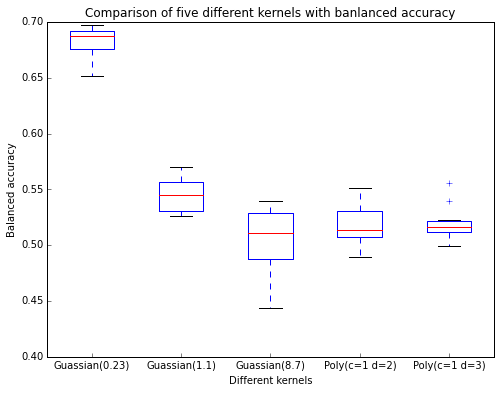

In [50]:
drawComparsionGraph(baMatrix_lambda4)